<a href="https://colab.research.google.com/github/gangadharpro/ADS-ASSIGNMENT-1/blob/main/data_hypertuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import joblib
import os
from flask import Flask, request, jsonify

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load original dataset for visualization
df= pd.read_csv("/content/drive/My Drive/UK-HPI-full-file-2024-01.csv")

In [6]:
# Convert 'Date' to DateTime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [6]:
# Select relevant columns
columns_to_keep = [
    'Date', 'RegionName', 'AveragePrice', 'SalesVolume',
    'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice',
    '1m%Change', '12m%Change', 'NewPrice', 'OldPrice'
]
df = df[columns_to_keep]

In [7]:
# Handling missing values
df.fillna(df.median(numeric_only=True), inplace=True)  # Numeric columns
df.fillna(df.mode().iloc[0], inplace=True)  # Categorical columns

In [8]:
df.isnull().sum()

,0
Date,0
RegionName,0
AveragePrice,0
SalesVolume,0
DetachedPrice,0
SemiDetachedPrice,0
TerracedPrice,0
FlatPrice,0
1m%Change,0
12m%Change,0


In [9]:
df.describe()

,Date,AveragePrice,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,1m%Change,12m%Change,NewPrice,OldPrice
count,12549,12549.000000,12549.000000,1.254900e+04,12549.000000,12549.000000,12549.000000,12549.000000,12549.000000,12549.000000,12549.000000
mean,2010-01-17 01:41:26.349509632,163738.882091,277.278668,2.752940e+05,173637.499583,139804.820235,107571.571093,0.510012,6.222916,191584.986459,161346.101940
min,1995-01-01 00:00:00,23100.734160,19.000000,4.064610e+04,25713.064540,20664.013160,16212.480670,-17.484095,-32.175901,34805.706750,22786.379950
25%,2003-03-01 00:00:00,98683.261430,135.666667,1.590335e+05,100073.344800,81339.062650,65397.000000,-0.489586,1.200000,125525.380600,98853.212540
50%,2010-04-01 00:00:00,139825.702500,206.000000,2.236114e+05,140555.737300,111454.288000,90951.878780,0.500000,5.300000,176836.310900,138935.706300
75%,2017-03-01 00:00:00,204124.019600,319.000000,3.244738e+05,209601.929000,172457.061900,134041.604800,1.493105,10.274687,234174.779100,200691.380100
max,2024-01-01 00:00:00,606765.000000,2124.000000,1.491863e+06,860793.000000,703884.000000,433600.000000,14.589547,61.885624,629545.000000,616340.000000
std,NaN,98074.271543,245.802093,1.965569e+05,123556.947126,99406.277963,68649.198058,2.040514,9.368936,102598.399394,96941.575722


In [10]:
# Selecting top 10 regions with highest average house prices
top_regions = df.groupby('RegionName')['AveragePrice'].mean().nlargest(10).index
df_top_regions = df[df['RegionName'].isin(top_regions)]

In [11]:
top_regions=df_top_regions

In [12]:
top_regions

,Date,RegionName,AveragePrice,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,1m%Change,12m%Change,NewPrice,OldPrice
241,1995-01-01,Adur,54516.42545,79.0,85482.01252,59598.67451,48955.96381,38126.03274,0.500000,5.3,59255.49943,54372.37389
242,1995-02-01,Adur,55708.33312,69.0,86608.15652,61135.57058,50152.49854,38788.83933,2.186328,5.3,60654.01325,55557.42782
243,1995-03-01,Adur,55724.54586,103.0,86386.66096,61125.69506,50266.10542,38801.15471,0.029103,5.3,60835.22587,55567.73779
244,1995-04-01,Adur,55440.83646,84.0,85566.09671,60824.13245,50102.15940,38616.39860,-0.509128,5.3,60471.94043,55286.75938
245,1995-05-01,Adur,53334.35175,77.0,82340.96480,58475.66019,48175.79230,37213.06360,-3.799518,5.3,58206.71489,53184.96713
...,...,...,...,...,...,...,...,...,...,...,...,...
12104,2023-09-01,Brentwood,472443.00000,74.0,878121.00000,532378.00000,394375.00000,268720.00000,1.100000,-0.5,414762.00000,478679.00000
12105,2023-10-01,Brentwood,461096.00000,73.0,857042.00000,519772.00000,384717.00000,262264.00000,-2.400000,-3.9,413454.00000,467139.00000
12106,2023-11-01,Brentwood,463418.00000,59.0,860444.00000,522759.00000,385476.00000,264358.00000,0.500000,-1.5,428690.00000,469430.00000
12107,2023-12-01,Brentwood,459284.00000,206.0,845328.00000,520304.00000,381938.00000,263483.00000,-0.900000,-2.9,176836.31090,138935.70630


In [13]:
# Splitting Data
X = df.drop(columns=['AveragePrice'])  # Features
y = df['AveragePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

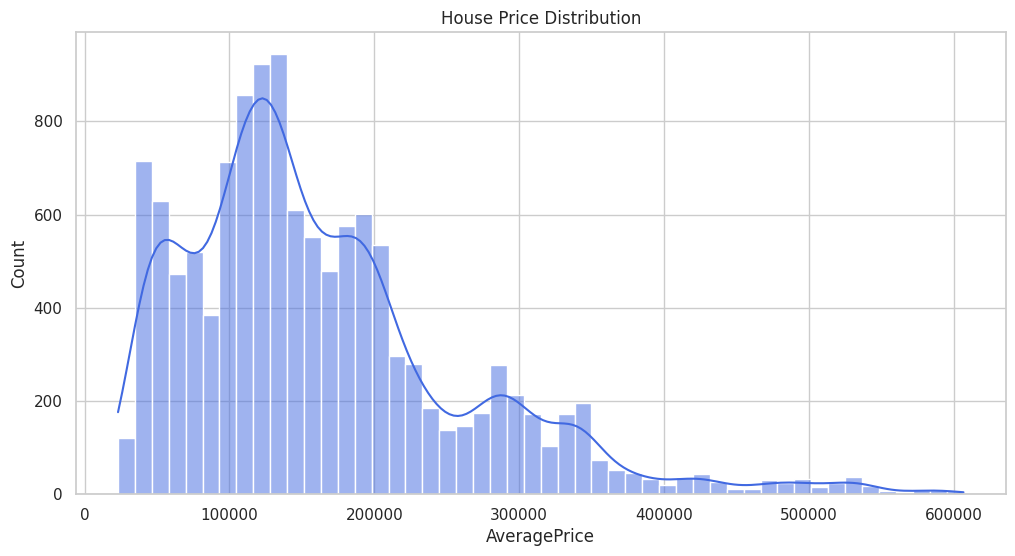

In [14]:
# 10+ Visualizations
sns.set(style="whitegrid")

# 1. House Price Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['AveragePrice'], bins=50, kde=True, color='royalblue')
plt.title("House Price Distribution")
plt.show()


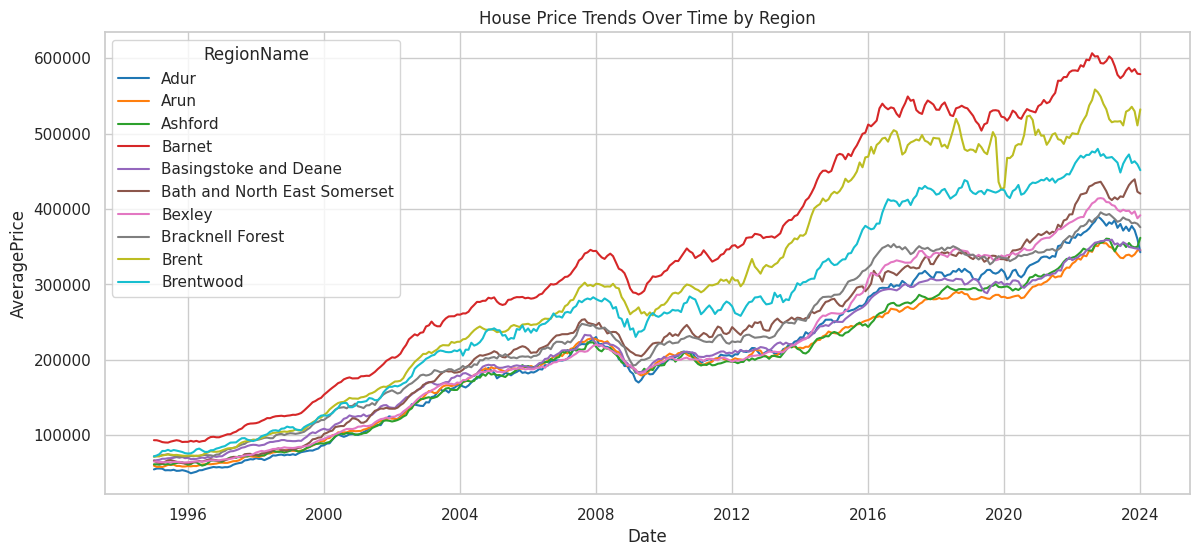

In [15]:
# 2. House Price Trends Over Time by Region
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='AveragePrice', data=top_regions, hue='RegionName', palette='tab10')
plt.title("House Price Trends Over Time by Region")
plt.show()

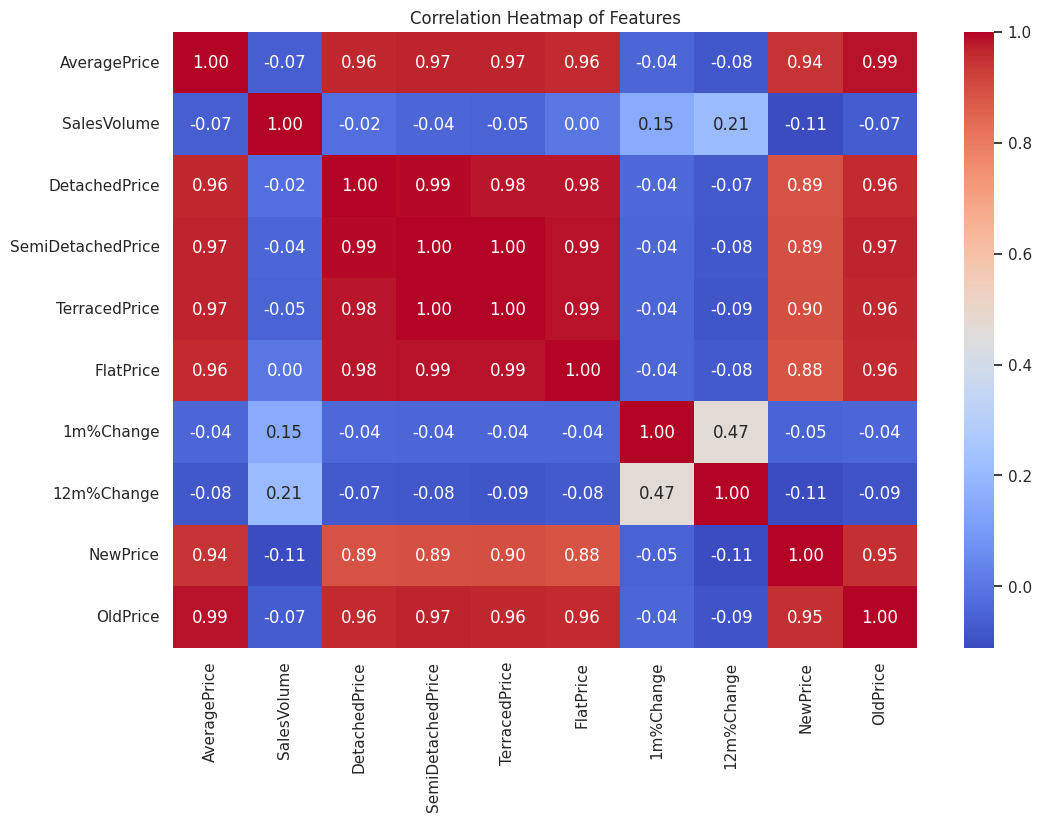

In [16]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Features")
plt.show()

<ipython-input-17-fae52b3f7512>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='RegionName', y='AveragePrice', data=df_top_regions, palette='coolwarm')


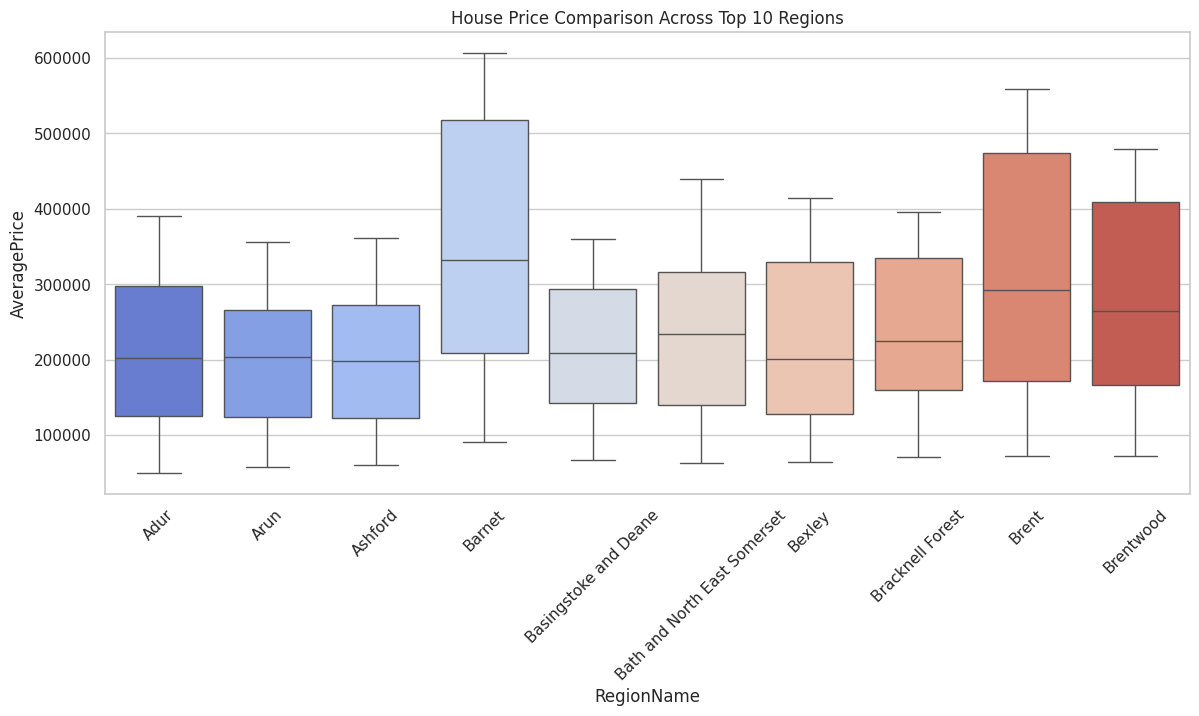

In [17]:
# 4. Boxplot Comparison for Property Types in Top 10 Regions
plt.figure(figsize=(14, 6))
sns.boxplot(x='RegionName', y='AveragePrice', data=df_top_regions, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("House Price Comparison Across Top 10 Regions")
plt.show()

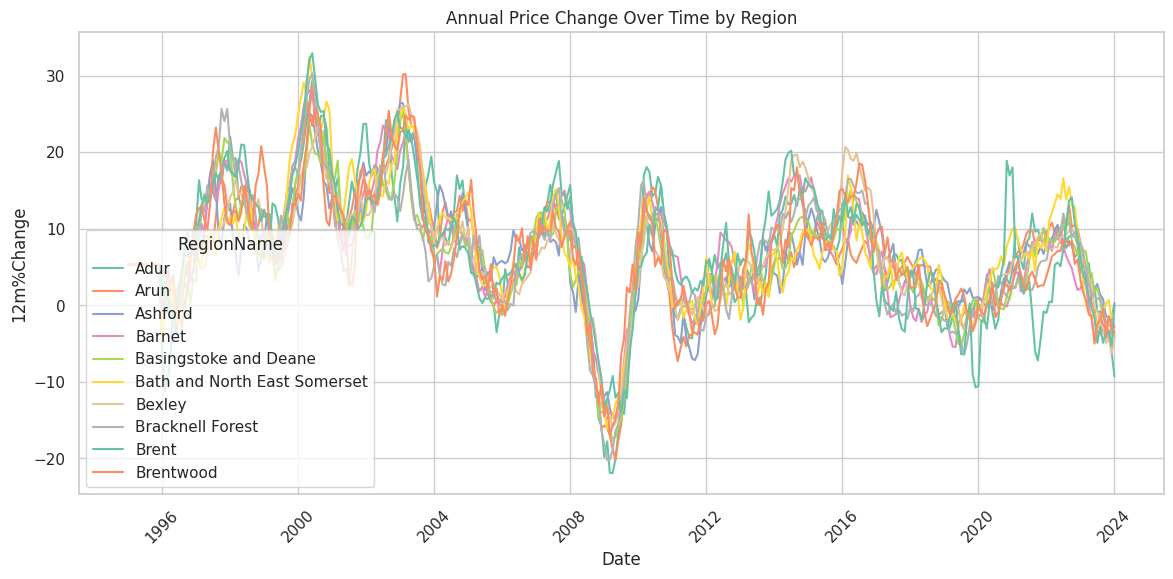

In [18]:
# 6. Annual Price Change Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='12m%Change', data=top_regions, hue='RegionName', palette='Set2')
plt.title("Annual Price Change Over Time by Region")
plt.xticks(rotation=45)
plt.show()

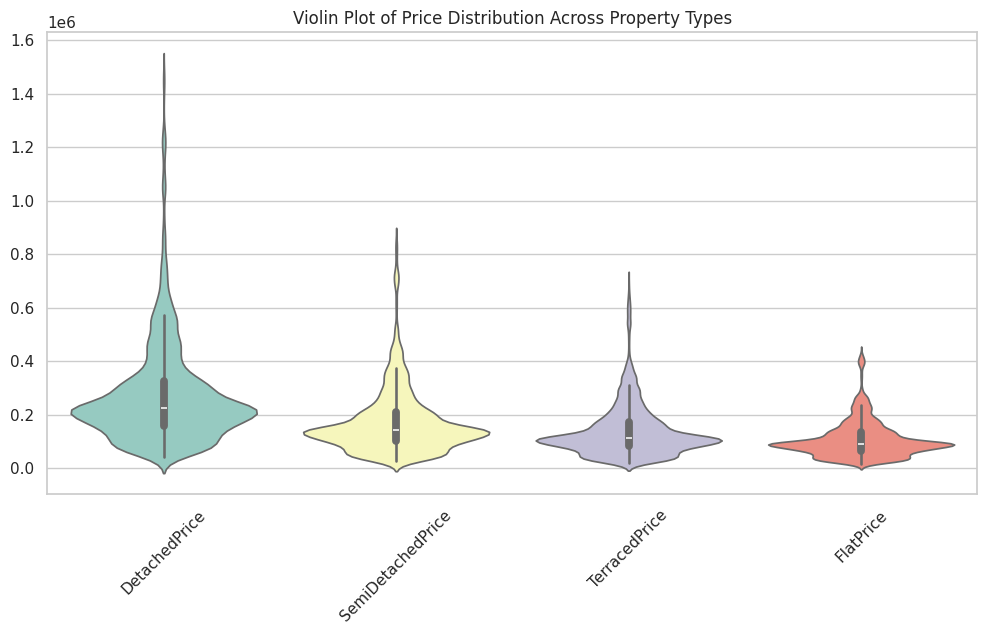

In [19]:
# 7. Violin Plot for Property Type Price Distribution
plt.figure(figsize=(12, 6))
sns.violinplot(data=df[['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice']], palette='Set3')
plt.title("Violin Plot of Price Distribution Across Property Types")
plt.xticks(rotation=45)
plt.show()

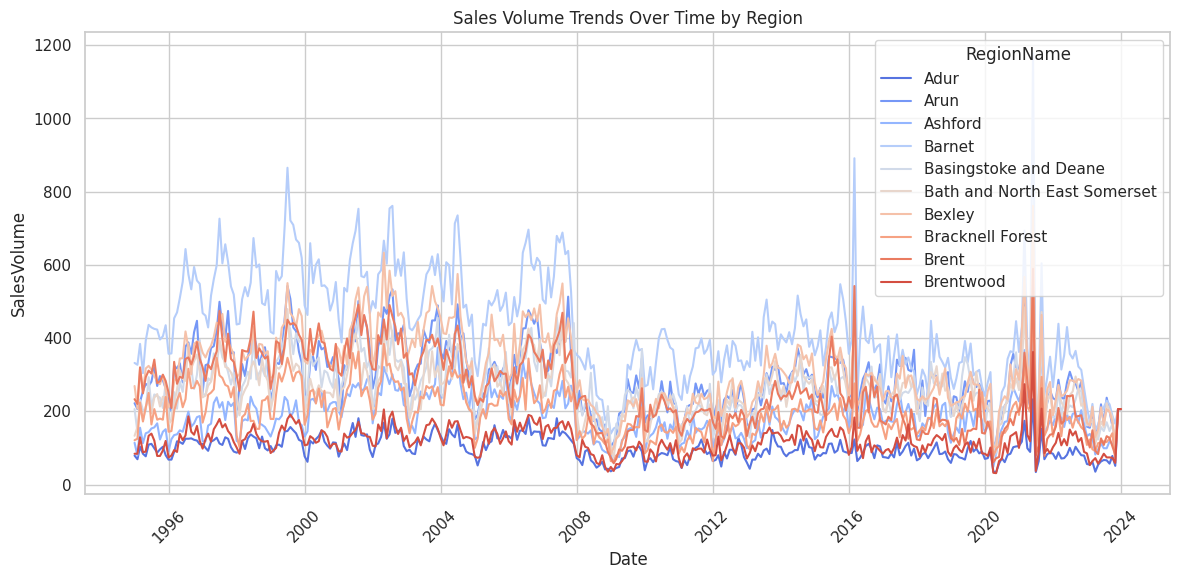

In [20]:
# 8. Sales Volume Trends Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='SalesVolume', data=top_regions, hue='RegionName', palette='coolwarm')
plt.title("Sales Volume Trends Over Time by Region")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Scaling numeric features
scaler = StandardScaler()
numeric_cols = ['AveragePrice', 'SalesVolume', 'DetachedPrice', 'SemiDetachedPrice',
                'TerracedPrice', 'FlatPrice', '1m%Change', '12m%Change', 'NewPrice', 'OldPrice']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [22]:
# Encoding categorical variables (RegionName)
le = LabelEncoder()
df['RegionName'] = le.fit_transform(df['RegionName'])

In [23]:
X = df.drop(columns=['AveragePrice', 'Date'])
y = df['AveragePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# 3. Hyperparameter Tuning for Random Forest

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
print("# 3. Hyperparameter Tuning")
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [10, 20, None],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best Parameters for Random Forest:", grid_search.best_params_)

# 3. Hyperparameter Tuning
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [29]:
print("# 4. Model Training & Evaluation")
models = {
"Linear Regression": LinearRegression(),
"Ridge Regression": Ridge(alpha=1.0),
"Lasso Regression": Lasso(alpha=0.1),
"ElasticNet": ElasticNet(alpha=0.1),
"Decision Tree": DecisionTreeRegressor(random_state=42),
"Random Forest": best_rf,  # Using the best-tuned Random Forest model
"Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
"Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
"AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
"Support Vector Regression": SVR(kernel='rbf')
}

results = {}
if not os.path.exists("saved_models"):os.makedirs("saved_models")

for name, model in models.items():model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
results[name] = {
"RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
"R2 Score": r2_score(y_test, y_pred),
"MAE": mean_absolute_error(y_test, y_pred),
"Cross-Val R2": cross_val
}
joblib.dump(model, f"saved_models/{name.replace(' ', '_').lower()}.pkl")

results_df = pd.DataFrame(results).T
display(results_df)

# 4. Model Training & Evaluation


,RMSE,R2 Score,MAE,Cross-Val R2
Support Vector Regression,0.14671,0.978103,0.073157,0.980839


In [26]:
#Identify the Best Model Based on R2 Score

best_model_name = results_df['R2 Score'].idxmax()
print(f"Best Model: {best_model_name} with R2 Score: {results_df.loc[best_model_name, 'R2 Score']}")



Best Model: Support Vector Regression with R2 Score: 0.9781029113615225


In [30]:
#4. Model Training & Evaluation

print("# 4. Model Training & Evaluation")
models = {
"Linear Regression": LinearRegression(),
"Ridge Regression": Ridge(alpha=1.0),
"Lasso Regression": Lasso(alpha=0.1),
"ElasticNet": ElasticNet(alpha=0.1),
"Decision Tree": DecisionTreeRegressor(random_state=42),
"Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42),
"Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
"Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
"AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
"Support Vector Regression": SVR(kernel='rbf')
}

results = {}
best_model_name = None
best_r2_score = float('-inf')

if not os.path.exists("saved_models"):os.makedirs("saved_models")

for name, model in models.items():print(f"Training {name}...")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()

# Convert results dictionary into a DataFrame
if results:
    results_df = pd.DataFrame.from_dict(results, orient='index')

    # Reset index to include model names
    results_df.reset_index(inplace=True)

    # Ensure correct number of columns before renaming
    if results_df.shape[1] == 5:
        results_df.columns = ["Model", "RMSE", "R2 Score", "MAE", "Cross-Val R2"]
    else:
        print("Warning: Column count mismatch in results_df. Printing as is.")

    # Display the formatted table
    print("\n### Model Performance Summary ###\n")
    display(results_df)

    # Print the best-performing model
    print(f"\nThe best performing model is: {best_model_name} with an R2 Score of {best_r2_score}\n")
else:
    print("No models were successfully trained. Please check your dataset and features.")



# 4. Model Training & Evaluation
Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet...
Training Decision Tree...
Training Random Forest...
Training Extra Trees...
Training Gradient Boosting...
Training AdaBoost...
Training Support Vector Regression...
No models were successfully trained. Please check your dataset and features.
